# 1. Hard SVM with 2 features and 10 samples

In [1]:

from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.utils import shuffle
data = datasets.load_iris()
from sklearn.preprocessing import StandardScaler

import jax.numpy as jnp
from jax import grad as fgrad
from jax import jit, vmap, jacfwd, jacrev, device_put
import numpy as np
from numpy.linalg import norm
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.autograd import grad
from scipy.integrate import solve_ivp
np.set_printoptions(suppress=True)
from matplotlib import pyplot as plt
import random
import jax

from copy import deepcopy

CUDA = torch.cuda.is_available()
mse = nn.MSELoss(reduction='none')
NUMERICAL_METHOD = 'RK45'

seed = 23

random.seed(seed)
# Set seed for NumPy
np.random.seed(seed)
# Set seed for PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU
# Set seed for JAX
key = jax.random.PRNGKey(seed)

In [2]:
def select_n_points(data_X, data_y, n):
    # Check if n is even
    if n % 2 != 0:
        raise ValueError("n must be an even number to select equal points from both classes.")

    # Separate the data into two classes: +1 and -1
    class_pos = data_X[data_y == 1]  # Class +1
    class_neg = data_X[data_y == -1]  # Class -1

    # Check if enough points exist in both classes
    if len(class_pos) < n // 2 or len(class_neg) < n // 2:
        raise ValueError("Not enough data points in one or both classes to select n points.")

    # Randomly select n//2 points from each class
    selected_pos = class_pos[np.random.choice(len(class_pos), n // 2, replace=False)]
    selected_neg = class_neg[np.random.choice(len(class_neg), n // 2, replace=False)]

    # Combine the selected points and their labels
    selected_X = np.vstack((selected_pos, selected_neg))
    selected_y = np.hstack((np.ones(n // 2), -np.ones(n // 2)))

    # Shuffle the selected points and labels
    selected_X, selected_y = shuffle(selected_X, selected_y, random_state=42)

    return selected_X, selected_y

In [3]:
X = data.data 
y = data.target
feature_names = data.feature_names

X = pd.DataFrame(X, columns=feature_names) 

# Filter out the rows where y is 2
mask = (y != 2)
X_filtered = X[mask]  # Only keep rows where y is not 2
y_filtered = y[mask]  # Only keep corresponding labels

# Encode y to be +1 and -1
le = LabelEncoder()
y_encoded = le.fit_transform(y_filtered)
y_encoded[y_encoded == 0] = -1  # Replace 0 with -1

# Now X_filtered contains the features and y_encoded contains the -1 and +1 labels
data_X = X_filtered[['sepal length (cm)', 'sepal width (cm)']].to_numpy()
data_y = y_encoded

In [4]:
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

[Text(0.5, 0, 'sepal length (cm)'), Text(0, 0.5, 'sepal width (cm)')]

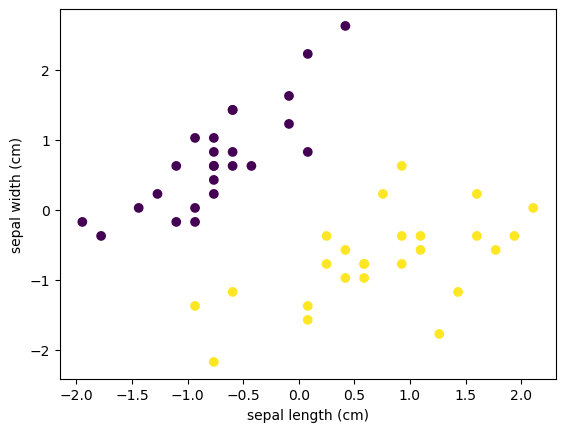

In [5]:
n = 50
selected_X, selected_y = select_n_points(data_X, data_y, n)
scaler = StandardScaler()
selected_X = scaler.fit_transform(selected_X)
_, ax = plt.subplots()
scatter = ax.scatter(selected_X[:, 0], selected_X[:, 1], c=selected_y)
ax.set(xlabel='sepal length (cm)', ylabel='sepal width (cm)')

In [6]:
# Define the plotting function
def plot_svm_decision_boundary(X, y, w, b, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Iris versicolor')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Iris setosa')

    # Plot decision boundary
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    # Use only the selected features for the decision boundary
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = np.dot(grid, w[[feature_x_idx, feature_y_idx]]) + b
    Z = Z.reshape(xx.shape)
    
    plt.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 1], alpha=0.5, linestyles=['--'])
    
    plt.xlabel(f'sepal length (cm)')
    plt.ylabel(f'sepal width (cm)')
    plt.legend()
    plt.title('Hard Margin SVM Decision Boundary')
    plt.show()
    
# Define the modified plotting function to plot two decision boundaries
def plot_svm_decision_boundary_confrontation(X, y, w_1, b_1, w_2, b_2, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Iris versicolor')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Iris setosa')

    # Create mesh grid for decision boundaries
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # First model's decision boundary (Ground Truth) in orange with highlight effect (thicker and transparent)
    Z1 = np.dot(grid, w_1[[feature_x_idx, feature_y_idx]]) + b_1
    Z1 = Z1.reshape(xx.shape)
    ground_truth = plt.contour(xx, yy, Z1, colors='purple', levels=[0], alpha=0.3, linewidths=5, linestyles=['-'])
    plt.contour(xx, yy, Z1, colors='purple', levels=[-1, 1], alpha=0.3, linewidths=3, linestyles=['--'])
    
    # Second model's decision boundary (ODE Solution) in purple
    Z2 = np.dot(grid, w_2[[feature_x_idx, feature_y_idx]]) + b_2
    Z2 = Z2.reshape(xx.shape)
    ode_solution = plt.contour(xx, yy, Z2, colors='green', levels=[0], alpha=0.8, linewidths=2, linestyles=['-'])
    plt.contour(xx, yy, Z2, colors='green', levels=[-1, 1], alpha=0.8, linewidths=1.5, linestyles=['--'])
    
    # Add the two main lines to the legend
    h1, _ = ground_truth.legend_elements()
    h2, _ = ode_solution.legend_elements()
    legend_elements = [h1[0], h2[0], 
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10)]
    legend_labels = ['Ground Truth', 'ODE Solution', 'Iris versicolor', 'Iris setosa']
    plt.legend(legend_elements, legend_labels, loc='upper right')
    
    # Add labels, title, and show the plot
    plt.xlabel(f'sepal length (cm)')
    plt.ylabel(f'sepal width (cm)')
    plt.title('SVM Decision Boundaries')
    plt.show()

In [7]:
def adjust_label_positions(positions, min_distance=0.02):
    """Adjust vertical positions of labels to avoid overlap."""
    sorted_positions = sorted(enumerate(positions), key=lambda x: x[1])
    adjusted_positions = positions.copy()
    
    for i in range(1, len(sorted_positions)):
        curr_idx, curr_pos = sorted_positions[i]
        prev_idx, prev_pos = sorted_positions[i-1]
        
        if curr_pos - prev_pos < min_distance:
            adjusted_positions[curr_idx] = prev_pos + min_distance
    
    return adjusted_positions

def plot_ode_system(t_values, y_values):
    plt.figure(figsize=(8, 6))
    # Enable LaTeX rendering
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Plot each line and prepare label information
    labels = [f'w_{i}' for i in range(1,3)] + ['b']
    colors = plt.cm.rainbow(np.linspace(0, 1, len(labels)))
    label_positions = []

    for i, (label, color) in enumerate(zip(labels, colors)):
        line = plt.plot(t_values, y_values[i, :], label=label, color=color)[0]
        label_positions.append(y_values[i, -1])

    # Adjust label positions
    y_min, y_max = np.min(y_values), np.max(y_values)
    y_range = y_max - y_min
    min_distance = 0.02 * y_range  # 2% of y-range as minimum distance
    adjusted_positions = adjust_label_positions(label_positions, min_distance)

    # Add adjusted labels with increased font size and space
    fontsize = 14  # Adjust the font size here
    x_offset = 1  # Space to move the label away from the line
    
    for i, (label, color, position) in enumerate(zip(labels[:3], colors[:3], adjusted_positions[:3])):
        math_label = f"${label}$"  # Add space with LaTeX's \quad
        x_end = t_values[-1]
        plt.text(x_end + x_offset, position, f' {math_label}', verticalalignment='center', 
                 horizontalalignment='left', color=color, fontsize=fontsize)

    plt.xlabel('Time', fontsize=fontsize)
    plt.ylabel('y(t)', fontsize=fontsize)
    plt.title('ODE System Solution', fontsize=fontsize)
    plt.grid(False)

    # Adjust the plot limits to make room for labels
    plt.xlim(t_values[0], t_values[-1] * 1.1)  # Extend x-axis by 10%
    plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)  # Extend y-axis by 10% on both ends

    plt.tight_layout()
    plt.show()

Time: 0.10042309761047363
Optimal objective value: 3.509303233699906
SCS solver iterations: 350
SCS solve time: 0.033716211999999995
SCS setup time: 0.035579435
Optimal w:  [ 1.93996577 -1.80420045]
Optimal b:  [0.328525]
Dual variables (Lagrange multipliers): [ 0.          3.50930322  0.          0.          2.95766996  0.
 -0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.55163269
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
Constraints: [-2.3278673   0.00000159 -0.91803294 -1.7704895  -0.00000259 -1.2786884
 -1.639344   -1.5409847  -0.9508194  -2.4918046  -1.2131145  -2.131149
 -0.49180472 -3.3770528  -1.8

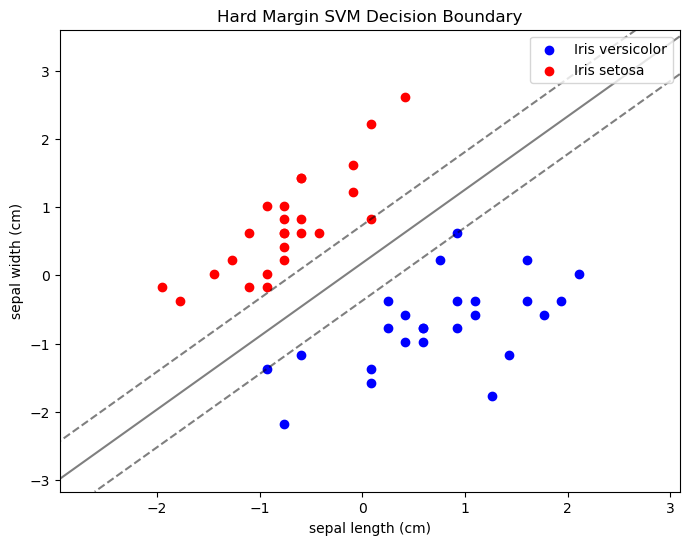

In [8]:
import cvxpy as cp
import numpy as np
import time

w = cp.Variable(2)
b = cp.Variable(1)

objective = cp.Minimize((1/2)*cp.norm(w, 2)**2)

constraints = [
    cp.multiply(selected_y, cp.matmul(selected_X, w) + b) >= 1,
]

problem = cp.Problem(objective, constraints)

t0 = time.time()
problem.solve(solver='SCS')
solve_time = time.time() - t0

# Get solver stats
solver_stats = problem.solver_stats
print('Time:', solve_time)
print('Optimal objective value:', problem.value)
print('SCS solver iterations:', solver_stats.num_iters)
print('SCS solve time:', solver_stats.solve_time)
print('SCS setup time:', solver_stats.setup_time)

# Get the values of the variables
print('Optimal w: ', w.value)
print('Optimal b: ', b.value)

# Get the dual variables
dual_variables = constraints[0].dual_value
print('Dual variables (Lagrange multipliers):', dual_variables)

g = [-selected_y[i] * (w.value @ selected_X[i] + b.value) + 1 for i in range(selected_y.shape[0])]
g_SCS = jnp.array(g).flatten()
print('Constraints:', g_SCS)

# Plotting
plot_svm_decision_boundary(selected_X, selected_y, w.value, b.value, 0, 1)

In [9]:
nw = selected_X.shape[1]
nb = 1
nx = nw + nb
nu = selected_X.shape[0]
NY = nx+nu

def f(x):
    w = x[:-1]
    output = (1/2) * jnp.linalg.norm(w, 2)**2
    return output

def g(x):
    w = x[:nw]
    b = x[nw]
    
    g = [-selected_y[i] * (w @ selected_X[i] + b) + 1 for i in range(selected_y.shape[0])]
    output = jnp.array(g)
    return output

df = fgrad(f) # jacobian of f
dg = jacrev(g) # jacobian of g

def P(xu): # projection mapping
    return xu

def ODE(t, xu):
    x, u = xu[:nx].reshape((nx, )), xu[nx:].reshape((nu, ))

    dx = df(x) + dg(x).T@jnp.clip(u+g(x), a_min=0)
    dx = -dx
    du = -u + jnp.clip(u+g(x), a_min=0)
    du = 0.5*du
    dxu = jnp.concatenate([dx, du], axis=0)
    return dxu

ODE = jit(ODE)

def evalutation(xu): # metric OuC(x_pred): check if inisde feasable region and return the objective value
    "return  f(x),    if g(x)<=0, f(x)=np.inf, if g(x)>0 "
    x, u= xu[:nx], xu[nx:]
    if (g(x)<=0.01).all():
        obj = f(x)
        #print('g(x) values:', g(x))
    else:
        obj = np.inf
        #print('g(x) values:', g(x))
    return obj

def constraints_diff(g_ODE, g_SCS):
    return jnp.abs(g_ODE - g_SCS).max()

In [10]:
def solve_ODE(xu0, T):
    sol = solve_ivp(ODE, [0., T], xu0, method=NUMERICAL_METHOD)
    result = P(sol.y[:, -1])
    print("objective:",evalutation(result))
    print("Constraints:",g(result[:nx]))
    diff = constraints_diff(g(result[:nx]), g_SCS)
    print("max diff:", diff.max(), "mean diff:", diff.mean())
    print("w diff:", jnp.abs(result[:nw] - w.value), "b diff:", jnp.abs(result[nw] - b.value))

    return sol, result

objective: 3.5075772
Constraints: [-2.3258872   0.00115916 -0.91767406 -1.7683412  -0.00117439 -1.2780681
 -1.6384621  -1.5410528  -0.9501438  -2.4914627  -1.2122355  -2.1310687
 -0.49234048 -3.3778262  -1.868084   -0.39403817 -1.4436435  -0.55728
 -1.9339166  -0.2934023  -1.8031445  -1.9654933  -1.1797657  -0.52481025
 -2.5865386  -0.49144748 -2.521599   -2.3917198  -1.3105378  -2.5239325
 -2.1319618  -1.7674482  -2.3267803  -4.981751   -2.228478   -1.868084
 -1.9988561  -0.16441624 -2.0336595  -1.2780681  -1.9005538   0.00205217
 -3.1148415  -1.0475531  -3.8031597  -3.77069    -0.62221956 -4.228493
 -1.508583   -2.3917198 ]
max diff: 0.0036211014 mean diff: 0.0036211014
w diff: [0.00032626 0.00130801] b diff: [0.00005385]


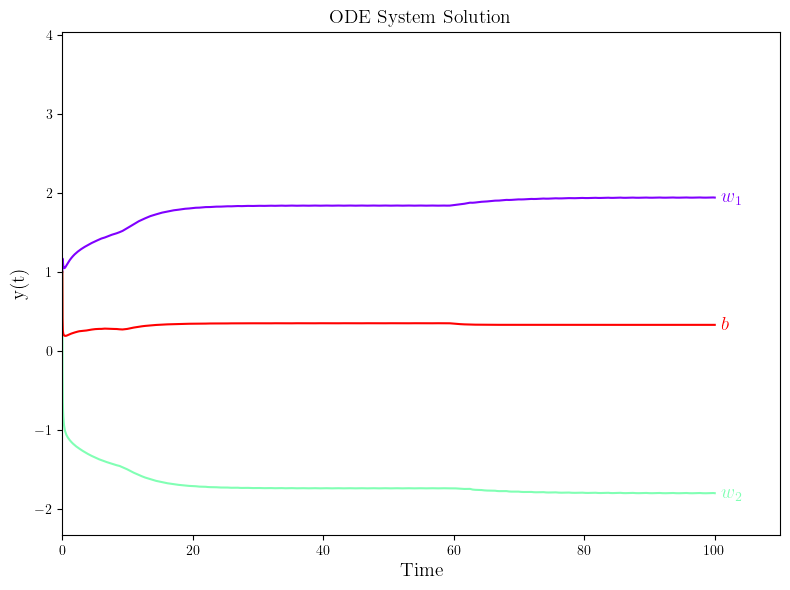

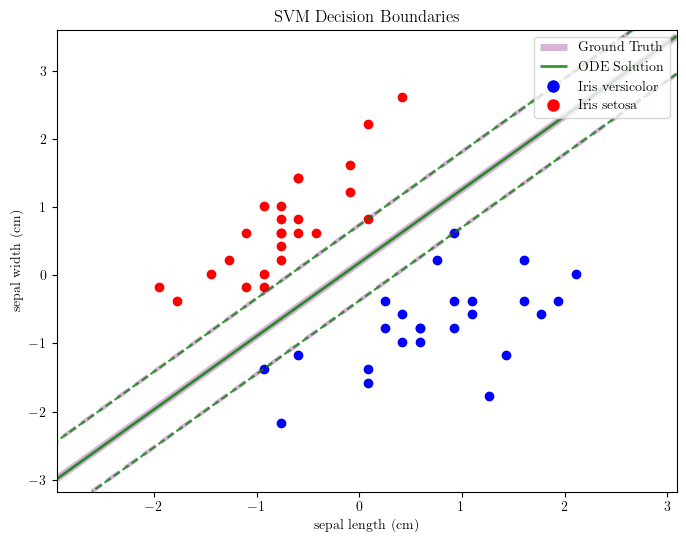

In [11]:
xu0 = jnp.zeros(NY)
xu0 = xu0.at[:nw + nb].set(1.0)

sol, result = solve_ODE(xu0, 100)

t_values = sol.t
y_values = sol.y

plot_ode_system(t_values, y_values)

plot_svm_decision_boundary_confrontation(selected_X, selected_y, w.value, b.value, result[:data_X.shape[1]], result[data_X.shape[1]], 0, 1)
w_ode = result[:data_X.shape[1]]
b_ode = result[data_X.shape[1]]

In [12]:
t0 = time.time()
sol, result = solve_ODE(xu0, 20)
solve_time = time.time() - t0
print('Time:', solve_time)

objective: inf
Constraints: [-2.1903245   0.07804354 -0.7631224  -1.598026    0.05272028 -1.1058124
 -1.4485025  -1.33636    -0.80050325 -2.3087294  -1.1248734  -1.9660393
 -0.3456706  -3.1125145  -1.7354919  -0.32735065 -1.2242174  -0.42043233
 -1.7164309  -0.28370744 -1.6607301  -1.8476344  -1.0874926  -0.38305146
 -2.3955488  -0.43949324 -2.320787   -2.1712635  -1.1431934  -2.3461103
 -1.8722167  -1.6918486  -2.0965018  -4.670179   -2.078182   -1.7354919
 -1.7911927  -0.04036139 -1.8538967  -1.1058124  -1.7728727  -0.01577908
 -2.881967   -0.9126458  -3.5299664  -3.4925854  -0.49519405 -3.947418
 -1.2989792  -2.1712635 ]
max diff: 0.31342745 mean diff: 0.31342745
w diff: [0.13348438 0.08987299] b diff: [0.01485324]
Time: 0.5198712348937988


In [13]:
t0 = time.time()
sol, result = solve_ODE(xu0, 50)
solve_time = time.time() - t0
print('Time:', solve_time)

objective: inf
Constraints: [-2.2409074   0.06411619 -0.7932522  -1.6388476   0.03431755 -1.1413182
 -1.4893842  -1.3772864  -0.8306181  -2.3647783  -1.1593438  -2.0167122
 -0.37045452 -3.1847808  -1.780744   -0.35111427 -1.2651888  -0.4451863
 -1.7627183  -0.30197537 -1.7060121  -1.8928416  -1.1219779  -0.4078204
 -2.4470773  -0.46321192 -2.3723454  -2.2228818  -1.1786841  -2.402144
 -1.9239548  -1.731605   -2.1481502  -4.763874   -2.12881    -1.780744
 -1.83745    -0.05975446 -1.9046146  -1.1413182  -1.8181099  -0.0286412
 -2.9488125  -0.94271576 -3.6075785  -3.5702126  -0.519918   -4.030376
 -1.3399206  -2.2228818 ]
max diff: 0.21973228 mean diff: 0.21973228
w diff: [0.10158734 0.06297991] b diff: [0.02048685]
Time: 1.0723257064819336


In [14]:
t0 = time.time()
sol, result = solve_ODE(xu0, 100)
solve_time = time.time() - t0
print('Time:', solve_time)

objective: 3.5075772
Constraints: [-2.3258872   0.00115916 -0.91767406 -1.7683412  -0.00117439 -1.2780681
 -1.6384621  -1.5410528  -0.9501438  -2.4914627  -1.2122355  -2.1310687
 -0.49234048 -3.3778262  -1.868084   -0.39403817 -1.4436435  -0.55728
 -1.9339166  -0.2934023  -1.8031445  -1.9654933  -1.1797657  -0.52481025
 -2.5865386  -0.49144748 -2.521599   -2.3917198  -1.3105378  -2.5239325
 -2.1319618  -1.7674482  -2.3267803  -4.981751   -2.228478   -1.868084
 -1.9988561  -0.16441624 -2.0336595  -1.2780681  -1.9005538   0.00205217
 -3.1148415  -1.0475531  -3.8031597  -3.77069    -0.62221956 -4.228493
 -1.508583   -2.3917198 ]
max diff: 0.0036211014 mean diff: 0.0036211014
w diff: [0.00032626 0.00130801] b diff: [0.00005385]
Time: 1.7503619194030762


In [15]:
t0 = time.time()
sol, result = solve_ODE(xu0, 500)
solve_time = time.time() - t0
print('Time:', solve_time)

objective: 3.5091057
Constraints: [-2.3271189   0.00047793 -0.91807604 -1.7696679  -0.00069215 -1.2786294
 -1.6391829  -1.5413191  -0.9506973  -2.4919448  -1.2128375  -2.1313913
 -0.49228013 -3.3778775  -1.8687017  -0.3938668  -1.4434553  -0.55752265
 -1.9344938  -0.29428345 -1.8034592  -1.9665655  -1.1802162  -0.5249014
 -2.5886385  -0.49173057 -2.523396   -2.392911   -1.3112507  -2.524566
 -2.1319408  -1.7691183  -2.3276684  -4.983197   -2.2292552  -1.8687017
 -1.9997363  -0.16434796 -2.0335276  -1.2786294  -1.901323    0.00102747
 -3.115188   -1.0485611  -3.8036735  -3.7710521  -0.6227651  -4.2294693
 -1.5086979  -2.392911  ]
max diff: 0.0015211105 mean diff: 0.0015211105
w diff: [0.0003731  0.00051059] b diff: [0.00002556]
Time: 6.987689971923828


In [16]:
sol, result = solve_ODE(xu0, 2000)

objective: 3.5091019
Constraints: [-2.3271027   0.0004884  -0.91807705 -1.7696499  -0.00070744 -1.2786282
 -1.6391795  -1.5413266  -0.9506947  -2.4919481  -1.2128315  -2.131397
 -0.49229065 -3.377896   -1.8686986  -0.39387625 -1.4434737  -0.5575259
 -1.9344954  -0.294266   -1.8034633  -1.9665514  -1.1802138  -0.5249083
 -2.5886052  -0.49172908 -2.5233698  -2.3928995  -1.3112459  -2.5245657
 -2.1319585  -1.7690884  -2.3276641  -4.9831886  -2.2292497  -1.8686986
 -1.9997306  -0.1643571  -2.033544   -1.2786282  -1.9013162   0.00104998
 -3.1151977  -1.0485475  -3.8036823  -3.7710648  -0.62276113 -4.229469
 -1.508709   -2.3928995 ]
max diff: 0.0015544891 mean diff: 0.0015544891
w diff: [0.00038144 0.00052175] b diff: [0.00002617]


# 3. The method

In [18]:
T=100.0

In [19]:
def g_batch(x):
    w = x[:, :nw]  # Extract w for each sample in the batch
    b = x[:, nw]   # Extract b for each sample in the batch

    # Compute g for each batch sample (2048) and constraint (10) using NumPy
    g = [[-selected_y[j] * (w[i] @ selected_X[j] + b[i]) + 1 for j in range(selected_y.shape[0])] for i in range(x.shape[0])]
    
    output = np.array(g)
    return output

In [20]:
class FNN(nn.Module):
    def __init__(self, y0):
        self.y0 = torch.tensor(y0, dtype=torch.float)
        if CUDA:
            self.y0 = self.y0.cuda()
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(1, NEURONS).cuda()
        self.linearL = []
        for _ in range(LAYERS-1):
            self.linearL.append(nn.Linear(NEURONS, NEURONS).cuda())
        self.linear2 = nn.Linear(NEURONS, NY).cuda()

    def forward(self, x):
        t = x.cuda()
        x = torch.tanh(self.linear1(x))
        for i in range(LAYERS-1):
            x = torch.tanh(self.linearL[i](x))
        x = self.linear2(x)
        x = self.y0 + (1 - torch.exp(-(t-0)))*x
        return x


class NN_NOP:
    def __init__(self, y0, time_range, P, ODE, C_epsilon): # P: projection mapping, ODE, C_epsilon: OuC metric
        self.y0 = np.array(y0)
        self.time_range = time_range # [0, 10]
        self.T = time_range[-1] # T=10
        self.P = P
        self.ODE = ODE
        self.C_epsilon = C_epsilon
        self.vODE = vmap(ODE, in_axes=(0, 0), out_axes=0)
        #self.numerical_method() # solve analyicallly the ODE

    def numerical_method(self):
        sol = solve_ivp(self.ODE, self.time_range, self.y0, method=NUMERICAL_METHOD)
        self.y_T_ODE = sol.y[:, -1] # get last value of the solution
        self.y_T_ODE = self.P(self.y_T_ODE) # project it
        self.y_T_ODE = np.array(self.y_T_ODE)
        self.epsilon_ODE = self.C_epsilon(self.y_T_ODE) # calculate OuC (f(x))

    def NN_method(self, weights=None, t_L=None):
        """
        train the nn, store the following four

        L_loss:  list, loss of batch during training
        L_epsilon: list, epsilon_best during training
        L_y_T: list, yT during training
        net_best:  the best neural network model during training
        """
        net = FNN(self.y0)
        if weights is not None:
            net.load_state_dict(weights.state_dict())
        if CUDA:
            net = net.cuda()
            
        optimizer = Adam(net.parameters(), lr=LR) # ========> 0.001 not looks good
        i = 0
        L_loss = []
        L_epsilon = []
        L_epsilon_curr = []
        L_y_T = []
        L_y_T_curr = []
        #L_y_iterations = []
        t0 = time.time()
        while True:
            # Update, L_epsilon, L_yT, net_best
            T = self.T*torch.ones((1, 1), dtype=torch.float)
            if CUDA:
                T = T.cuda()
            y_T = self.P_multiple(T, net) # get the output of the nn at T (last time)
            L_y_T_curr.append(y_T)

            epsilon_current = self.C_epsilon(y_T) # calculate OuC (f(x))
            L_epsilon_curr.append(epsilon_current)
            if i==0: # if first iteration
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
                #L_y_iterations.append(self.y_iteration(net_best))
            # if i==10:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==20:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==ITERATIONS-1:
            #L_y_iterations.append(self.y_iteration(net_best)) # store the output of the best nn across the time
            if epsilon_current < epsilon_best:
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
            L_epsilon.append(epsilon_best) # store the best OuC
            L_y_T.append(y_T_best) # store the best output of the nn at T

            # TRAIN MODEL
            # Prepare input t, torch.tensor (NBATCH, 1)
            if t_L is not None:
                t = t_L[i]
            else:
                t = np.random.uniform(0, self.T, (NBATCH, 1))
                #t = np.random.uniform(0, 1, (NBATCH, 1))
                #t = self.T * (t ** 2)  # Where alpha > 1 biases towards smaller values
            t = torch.tensor(t, dtype=torch.float, requires_grad=True)
            if CUDA:
                t = t.cuda()
            # Learning, L_loss
            loss = self.loss_compute(t, net)
            loss.backward()
            L_loss.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()
            # Monitor
            if i%100==0:
            # if i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                #print(f'T: {self.T}, y_T_ODE: {self.y_T_ODE.round(4)}, epsilon_ODE: {self.epsilon_ODE :.4f},  Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}, ||y_T_ODE-y_T_best||_2: {y_T_error :.4f}')
                #print(f'T: {self.T}, Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}')
                pass
            i = i+1
            
            torch.cuda.empty_cache()
            
            if i==ITERATIONS:
                break

        return L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time.time()-t0

    def loss_compute(self, t, net):
        # nn output xu, torch.tensor (NBATCH, nxu)
        y = net(t)

        # => Get ODE derivatives
        # True dxu, torch.tensor (NBATCH, nxu)
        t_cpu = t.cpu().detach().numpy()
        y_cpu = y[:, :].cpu().detach().numpy()
        dy = self.vODE(t_cpu, y_cpu)
        dy = np.array(dy)
        
        dy = torch.tensor(dy, dtype=torch.float)
        if CUDA:
            dy = dy.cuda()

        # => Get NN derivatives (autograd)
        # Predicted pdxu, torch.tensor (NBATCH, nxu)
        pdy = []
        for j in range(NY): # for all outputs node (for all variables)
            # y[:, [j]]: outputs of the nn for the j-th variable (all t of the batch), t: inputs of the nn, grad_outputs: scale the gradients to facilitate the compuation of the jacobian, Craete_graph: to compute higer order derivatives
            pdyi = grad(y[:, [j]], t, grad_outputs=torch.ones_like(y[:, [j]]), create_graph=True)[0] # torch autograd shape [NBATCH, 1]
            pdy.append(pdyi)
        pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]
        #pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]

        # Compute loss, torch.tensor a float
        dynamics_loss = mse(dy, pdy) # [NBATCH, NY]
        dynamics_loss = torch.sum(dynamics_loss, axis=1) # [NBATCH]
        dynamics_loss = torch.exp(-WEIGTHING*(t / T).detach().reshape((-1, )))*dynamics_loss  # proprity smaller t
        dynamics_loss = torch.mean(dynamics_loss, axis=0)
        
        return dynamics_loss

    def P_multiple(self, t, net): # get the projection of the output of the nn (for multiple t)
        y = net(t)
        y = y.reshape((-1, )).cpu().detach().numpy()
        output = self.P(y)
        output = np.array(output)
        return output

    def y_iteration(self, net): # get the ODE system estiamtion across the time
        # For L_y
        t = torch.arange(0, self.T, 0.1).reshape((-1, 1))
        if CUDA:
            t = t.cuda()
        y = [self.P_multiple(t[i].reshape((1,1)), net) for i in range(t.shape[0])]
        y = torch.tensor(np.array(y)).cpu().detach().numpy()

        return y # [T, NY]


In [21]:
y0 = np.zeros(NY)
y0[:nw + nb] = 1.0

In [22]:
def try_layers(l_list, n, lr):
     NEURONS = n
     LR = lr
     res = []
     for l in l_list:
          LAYERS = l
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_, 'time:', time)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_, 'time': time})
     return res

def try_neurons(n_list, l, lr):
     LAYERS = l
     LR = lr
     res = []
     for n in n_list:
          NEURONS = n
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_, 'time:', time)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_, 'time': time})
     return res

def try_lr(lr_list, l, n):
     LAYERS = l
     NEURONS = n
     res = []
     for lr in lr_list:
          LR = lr
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_, 'time:', time)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_, 'time': time})
     return res

def plot_results(res, y_max=50):
    fig, axes = plt.subplots(1, len(res), figsize=(20, 6))
    y_min = 0
    for i in range(len(res)):
        # Plot on the first subplot
        axes[i].plot(res[i]['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
        axes[i].plot(res[i]['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
        axes[i].set_xlabel('iteration')
        axes[i].set_ylabel('OuC metric')
        axes[i].set_title(f'l={res[i]["layers"]}, n={res[i]["neurons"]}, lr={res[i]["lr"]}')
        axes[i].legend()
        axes[i].grid(True)
        axes[i].set_ylim(y_min, y_max)
        axes[i].set_xlim(0, ITERATIONS)
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    # Show the plot
    plt.show()

def plot_result_confrontation(res):
     plt.figure(figsize=(6, 5))
     for r in res:
          plt.plot(r['L_epsilon'], marker='o', linestyle='-', label=f'l={r["layers"]}, n={r["neurons"]}, lr={r["lr"]}', markersize=1)
     # Add labels, title, legend and grid
     plt.xlabel('iteration')
     plt.ylabel('OuC metric')
     plt.title('Numbers of layers')
     plt.legend()  # Show the legend to distinguish the datasets
     plt.grid(False)
     plt.show()

def plot_hyperplane(r):
     net = r['net']
     epsilon = net(torch.tensor([[T]]).cuda()).cpu().detach().numpy()
     w_net = epsilon[0][:selected_X.shape[1]]
     b_net = epsilon[0][selected_X.shape[1]]
     # Plotting
     plt.figure(figsize=(10, 8))
     plt.scatter(selected_X[selected_y > 0][:, 0], selected_X[selected_y > 0][:, 1], c='b', label='Class 1')
     plt.scatter(selected_X[selected_y < 0][:, 0], selected_X[selected_y < 0][:, 1], c='r', label='Class -1')

     # Plot the decision boundary
     x_min, x_max = selected_X[:, 0].min() - 1, selected_X[:, 0].max() + 1
     y_min, y_max = selected_X[:, 1].min() - 1, selected_X[:, 1].max() + 1
     xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
     Z = np.dot(np.c_[xx.ravel(), yy.ravel()], w_net) + b_net
     Z = Z.reshape(xx.shape)
     plt.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])

     # Plot the margins
     plt.contour(xx, yy, Z, colors='k', levels=[-1, 1], alpha=0.5, linestyles=['--'])

     plt.xlabel('Feature 1')
     plt.ylabel('Feature 2')
     plt.legend()
     plt.title('Hard Margin SVM Decision Boundary')
     plt.show()

def print_error(r):
     net = r['net']
     epsilon = net(torch.tensor([[T]]).cuda()).cpu().detach().numpy()
     # Split epsilon into weights and bias
     w_net = epsilon[0][:selected_X.shape[1]]  # All weights
     b_net = epsilon[0][selected_X.shape[1]]   # Bias

     # Calculate absolute differences for weights and bias
     w_abs_diff = np.abs(w_ode - w_net)         # Vector for all weights
     b_abs_diff = np.abs(b_ode - b_net)      # Single value for bias

     # Calculate squared differences
     w_sq_diff = w_abs_diff ** 2               # Vector for squared differences of weights
     b_sq_diff = b_abs_diff ** 2               # Squared difference for bias

     # Calculate the Mean Squared Error (MSE)
     mse_ = (np.sum(w_sq_diff) + b_sq_diff) / (len(w_sq_diff) + 1)

     # Print the absolute differences for all weights and bias
     print('w absolute differences:', w_abs_diff)
     print('b absolute difference:', b_abs_diff)

     # Print the MSE
     print('\nMSE between the two solutions:', mse_)

def get_error(r):
     net = r['net']
     epsilon = net(torch.tensor([[T]], dtype=torch.float32).cuda()).cpu().detach().numpy()
     # Split epsilon into weights and bias
     w_net = epsilon[0][:selected_X.shape[1]]  # All weights
     b_net = epsilon[0][selected_X.shape[1]]   # Bias

     # Calculate absolute differences for weights and bias
     w_abs_diff = np.abs(w_ode - w_net)         # Vector for all weights
     b_abs_diff = np.abs(b_ode - b_net)      # Single value for bias

     # Calculate squared differences
     w_sq_diff = w_abs_diff ** 2               # Vector for squared differences of weights
     b_sq_diff = b_abs_diff ** 2               # Squared difference for bias

     # Calculate the Mean Squared Error (MSE)
     mse_ = (np.sum(w_sq_diff) + b_sq_diff) / (len(w_sq_diff) + 1)

     return mse_

In [23]:
def plot_svm_decision_boundary_confrontation_PINN(X, y, w_1, b_1, w_2, b_2, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Iris versicolor')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Iris setosa')

    # Create mesh grid for decision boundaries
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # First model's decision boundary (Ground Truth) in orange with highlight effect (thicker and transparent)
    Z1 = np.dot(grid, w_1[[feature_x_idx, feature_y_idx]]) + b_1
    Z1 = Z1.reshape(xx.shape)
    ground_truth = plt.contour(xx, yy, Z1, colors='purple', levels=[0], alpha=0.3, linewidths=5, linestyles=['-'])
    plt.contour(xx, yy, Z1, colors='purple', levels=[-1, 1], alpha=0.3, linewidths=3, linestyles=['--'])
    
    # Second model's decision boundary (ODE Solution) in purple
    Z2 = np.dot(grid, w_2[[feature_x_idx, feature_y_idx]]) + b_2
    Z2 = Z2.reshape(xx.shape)
    ode_solution = plt.contour(xx, yy, Z2, colors='green', levels=[0], alpha=0.8, linewidths=2, linestyles=['-'])
    plt.contour(xx, yy, Z2, colors='green', levels=[-1, 1], alpha=0.8, linewidths=1.5, linestyles=['--'])
    
    # Add the two main lines to the legend
    h1, _ = ground_truth.legend_elements()
    h2, _ = ode_solution.legend_elements()
    legend_elements = [h1[0], h2[0], 
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10)]
    legend_labels = ['ODE Solution', 'PINN Solution', 'Iris versicolor', 'Iris setosa']
    plt.legend(legend_elements, legend_labels, loc='upper right')
    
    # Add labels, title, and show the plot
    plt.xlabel(f'sepal length (cm)')
    plt.ylabel(f'sepal width (cm)')
    plt.title('SVM Decision Boundaries')
    plt.show()

LAYERS: 1 NEURONS: 100 LR: 0.01 epsilon: 4.12395 MSE solution: 0.03292593591654249 time: 142.8320837020874
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: inf MSE solution: 3.0929547233430803 time: 146.5963032245636
LAYERS: 3 NEURONS: 100 LR: 0.01 epsilon: inf MSE solution: 2.5707468421448008 time: 147.92123317718506
LAYERS: 4 NEURONS: 100 LR: 0.01 epsilon: 4.0367556 MSE solution: 0.020595198717612177 time: 128.70533394813538
LAYERS: 5 NEURONS: 100 LR: 0.01 epsilon: 13.2049055 MSE solution: 2.249216921135615 time: 134.04011869430542


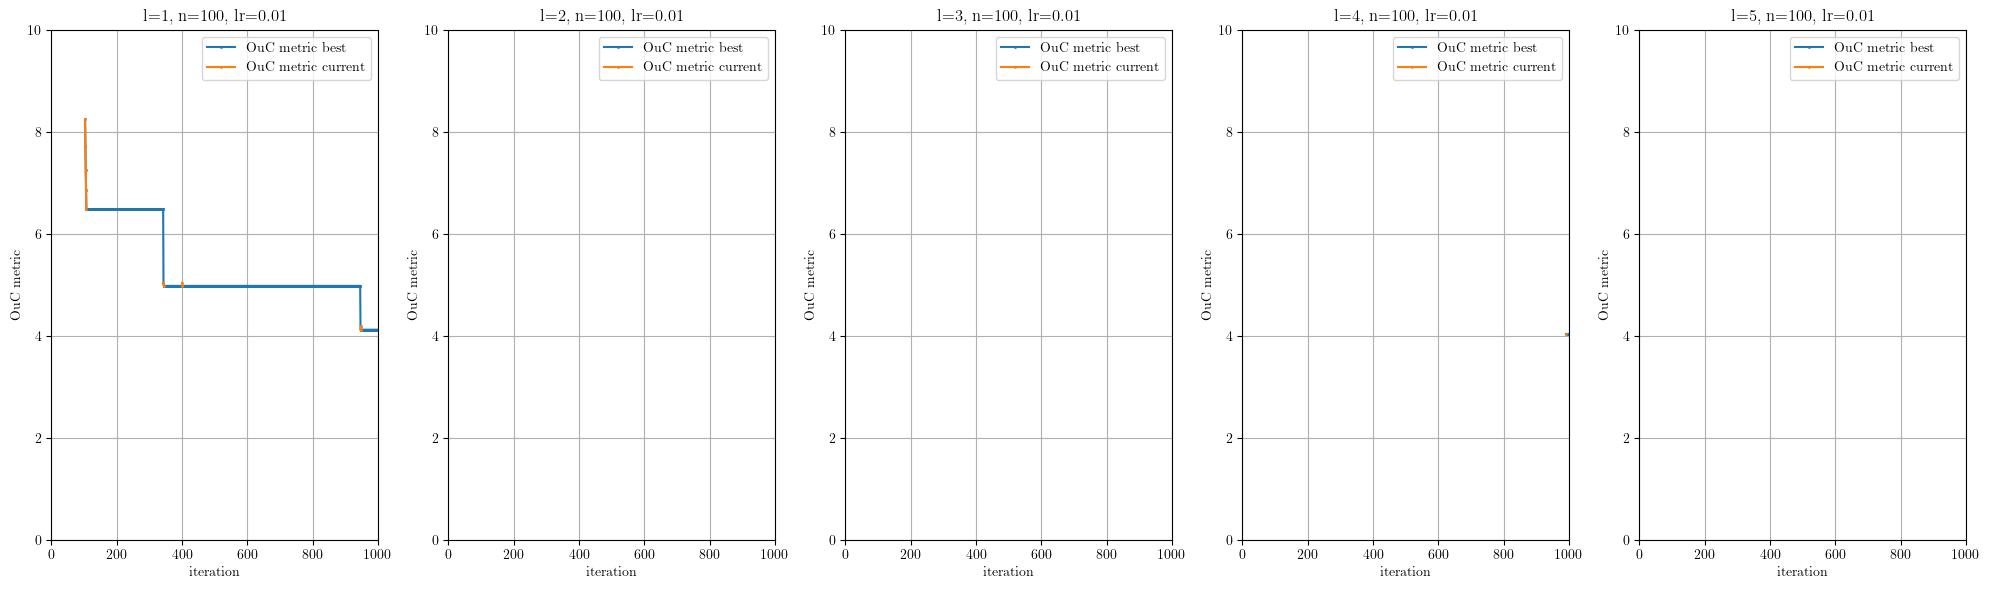

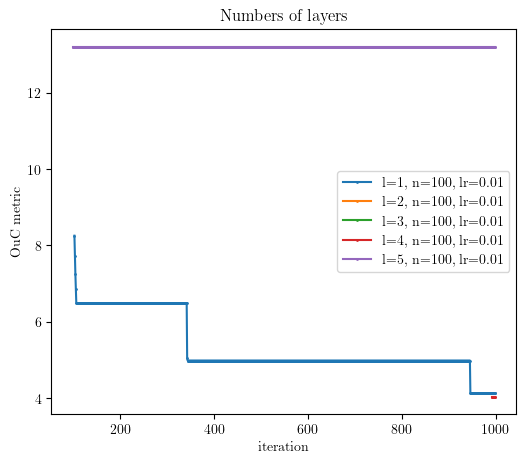

In [24]:
NBATCH = 512
ITERATIONS = 1000
WEIGTHING = 3
NEURONS=100
LR=0.01
LAYERS=2
res_layers = try_layers([1, 2, 3, 4, 5], 100, 0.01)
plot_results(res_layers, y_max=10)
plot_result_confrontation(res_layers)

LAYERS: 2 NEURONS: 50 LR: 0.01 epsilon: 5.0524216 MSE solution: 0.09605042149392896 time: 126.10195255279541
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: inf MSE solution: 3.0431638844602724 time: 124.06082057952881
LAYERS: 2 NEURONS: 200 LR: 0.01 epsilon: 4.7641673 MSE solution: 0.07636881737844158 time: 126.97348928451538
LAYERS: 2 NEURONS: 300 LR: 0.01 epsilon: 3.7562613 MSE solution: 0.004305540305057853 time: 127.09422898292542
LAYERS: 2 NEURONS: 400 LR: 0.01 epsilon: 3.6534295 MSE solution: 0.0031674510428023324 time: 125.25868582725525


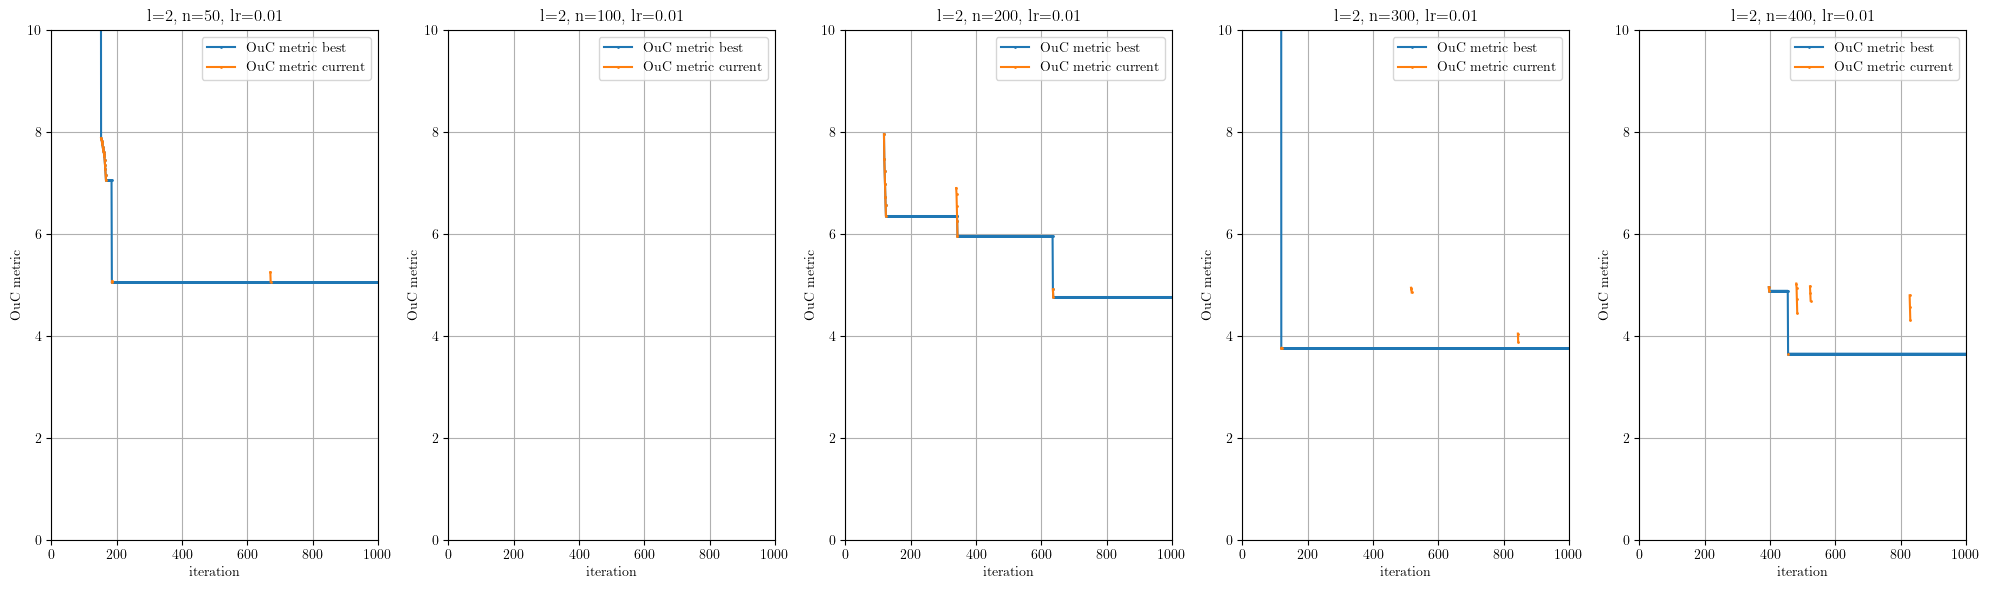

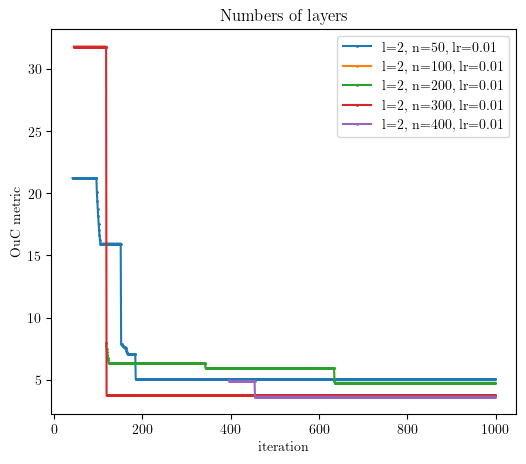

In [25]:
res_neurons = try_neurons([50, 100, 200, 300, 400], 2, 0.01)
plot_results(res_neurons, y_max=10)
plot_result_confrontation(res_neurons)

LAYERS: 2 NEURONS: 100 LR: 0.0001 epsilon: 4.1388288 MSE solution: 0.01801217616499201 time: 124.01032829284668
LAYERS: 2 NEURONS: 100 LR: 0.001 epsilon: 5.106173 MSE solution: 0.1467123804549478 time: 120.70735692977905
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 4.1509147 MSE solution: 0.0213284225337738 time: 124.80765318870544
LAYERS: 2 NEURONS: 100 LR: 0.1 epsilon: 3.8422472 MSE solution: 0.0066019587562811365 time: 123.28487491607666


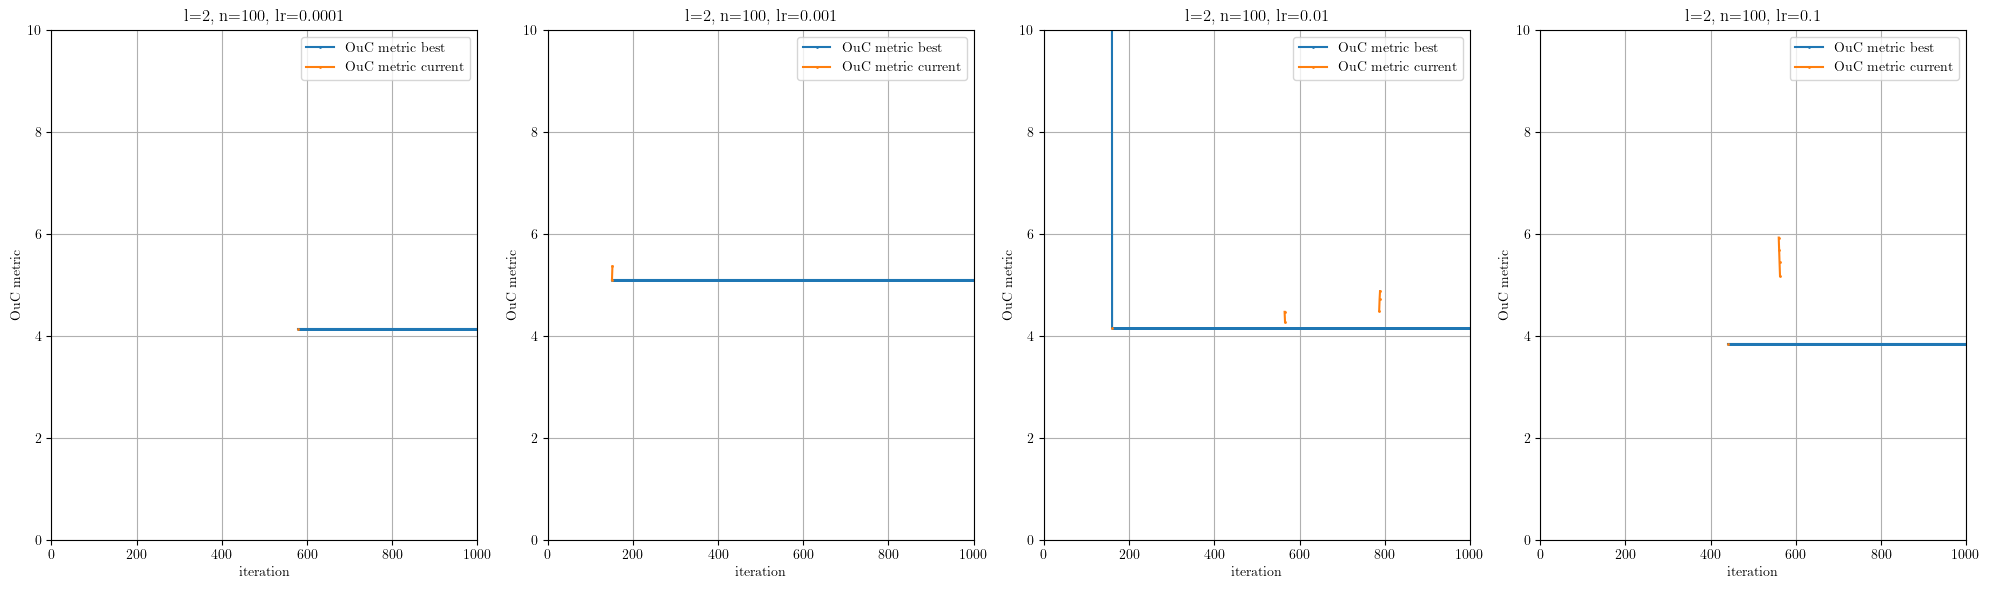

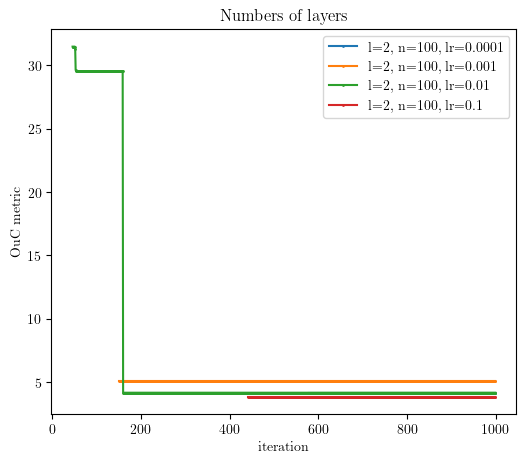

In [26]:
res_learning_rate = try_lr([0.0001, 0.001, 0.01, 0.1], 2, 100)
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

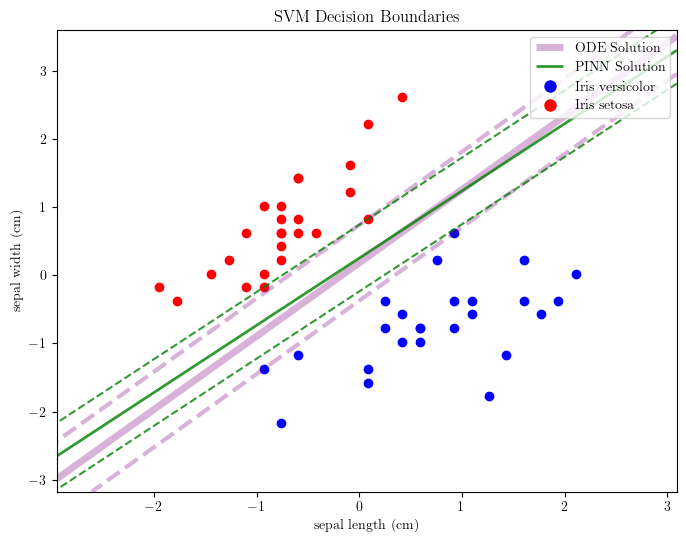

Variables: [ 2.0164785 -2.0449243  0.5150516]
Constraints: [-2.8997877  -0.00551975 -0.8919703  -1.9814225  -0.1072576  -1.3007458
 -1.7095215  -1.5055957  -0.95994556 -2.9007115  -1.6054854  -2.491936
 -0.3472441  -3.7191868  -2.2870862  -0.58400846 -1.30167    -0.48319465
 -1.9823465  -0.71903497 -2.1511357  -2.491012   -1.5375103  -0.4152194
 -3.0028996  -0.78793424 -2.866949   -2.595048   -1.3687211  -2.9686868
 -2.051246   -2.4221127  -2.4590974  -5.6941657  -2.6958618  -2.2870862
 -2.118297   -0.00644378 -2.2880101  -1.3007458  -2.3550615  -0.4462099
 -3.514337   -1.1638713  -4.263913   -4.1959376  -0.61914515 -4.808639
 -1.4376204  -2.595048  ]


In [27]:
net = res_layers[0]['net']
res = net(torch.tensor([T]).cuda()).cpu().detach().numpy()
plot_svm_decision_boundary_confrontation_PINN(selected_X, selected_y, w_ode, b_ode, res[:data_X.shape[1]], res[data_X.shape[1]], 0, 1)
print('Variables:', res[:nx])
print('Constraints:', g(res[:nx]))

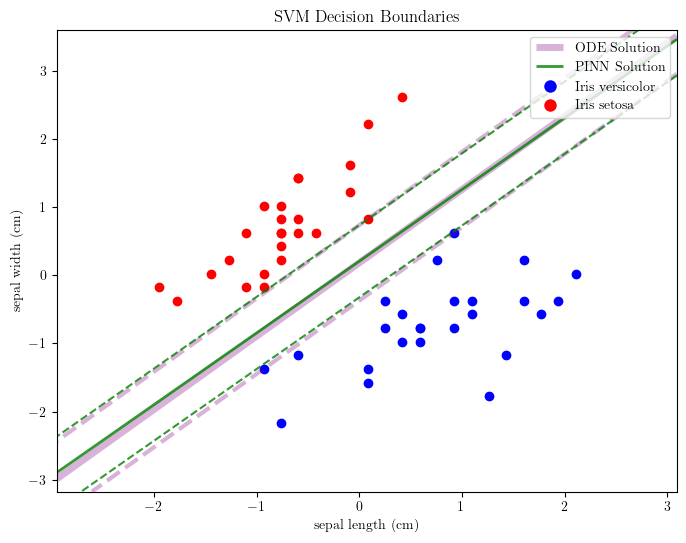

Variables: [ 1.9870507  -1.8878963   0.38890684]
Constraints: [-2.523906   -0.00472698 -0.92908883 -1.8500981  -0.05179316 -1.3064749
 -1.683861   -1.5591832  -0.9706481  -2.6519365  -1.3501885  -2.2745504
 -0.4685842  -3.534739   -2.0218422  -0.47073853 -1.4345053  -0.55170274
 -1.9781286  -0.42582667 -1.9387236  -2.14652    -1.3086293  -0.51014346
 -2.7295482  -0.59541637 -2.6464295  -2.4801924  -1.3480343  -2.6934958
 -2.1477182  -1.9769303  -2.397074   -5.25208    -2.3992283  -2.0218422
 -2.061247   -0.1327574  -2.1498725  -1.3064749  -2.0634015  -0.13155913
 -3.2820308  -1.095326   -3.9952438  -3.9536846  -0.6348213  -4.4557486
 -1.5176239  -2.4801924 ]


In [28]:
net = res_neurons[3]['net']
res = net(torch.tensor([T]).cuda()).cpu().detach().numpy()
plot_svm_decision_boundary_confrontation_PINN(selected_X, selected_y, w_ode, b_ode, res[:data_X.shape[1]], res[data_X.shape[1]], 0, 1)
print('Variables:', res[:nx])
print('Constraints:', g(res[:nx]))

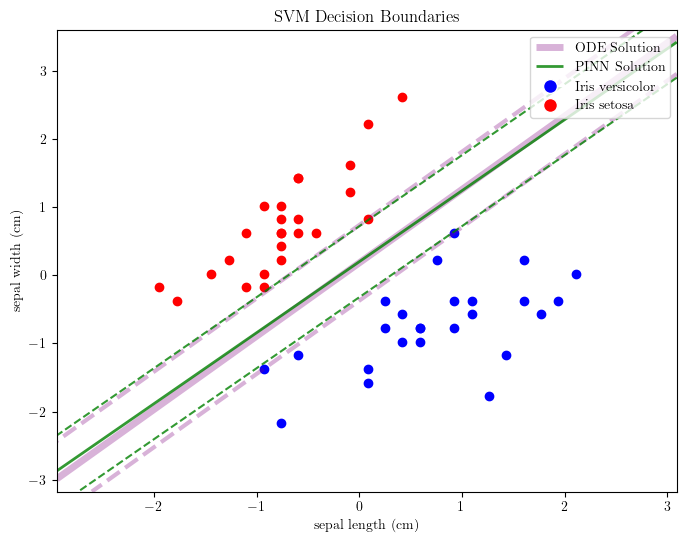

Variables: [ 1.9999186  -1.9195888   0.38167346]
Constraints: [-2.5676384  -0.03701773 -0.959583   -1.9099047  -0.03671156 -1.3433043
 -1.7270256  -1.5898664  -1.0053028  -2.6770413  -1.3707546  -2.29332
 -0.48442212 -3.5538867  -2.0467577  -0.46615267 -1.4527072  -0.57586163
 -2.0193076  -0.44818938 -1.9553183  -2.183917   -1.3250349  -0.5301419
 -2.8145068  -0.60331196 -2.723067   -2.540188   -1.3890241  -2.722761
 -2.1744301  -2.0287945  -2.4487486  -5.317371   -2.430479   -2.0467577
 -2.110747   -0.14642052 -2.1561606  -1.3433043  -2.0924776  -0.15590754
 -3.3073246  -1.142462   -4.0290475  -3.9833279  -0.6673011  -4.5042086
 -1.5441467  -2.540188  ]


In [29]:
net = res_learning_rate[3]['net']
res = net(torch.tensor([T]).cuda()).cpu().detach().numpy()
plot_svm_decision_boundary_confrontation_PINN(selected_X, selected_y, w_ode, b_ode, res[:data_X.shape[1]], res[data_X.shape[1]], 0, 1)
print('Variables:', res[:nx])
print('Constraints:', g(res[:nx]))

In [30]:
NBATCH = 512
ITERATIONS = 1000
WEIGTHING = 3

In [31]:
LAYERS = 2
NEURONS = 100
LR = 0.01
import time
example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, t = example.NN_method() # train
mse_ = get_error({'net': net_best})
print('LAYERS:', LAYERS, 'NEURONS:', NEURONS, 'LR:', LR, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_, 'time:', t)
res = {'layers': LAYERS, 'neurons': NEURONS, 'lr': LR, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_, 'time': time}

LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 3.5263958 MSE solution: 0.00033267938761747377 time: 122.08813381195068


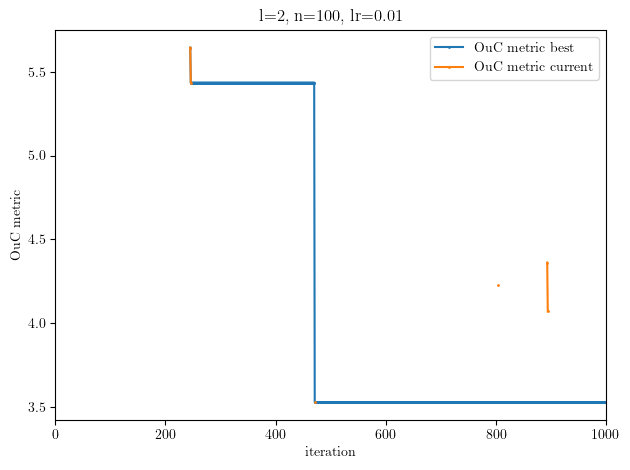

In [32]:


plt.plot(res['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
plt.plot(res['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
plt.xlabel('iteration')
plt.ylabel('OuC metric')
plt.title(f'l={res["layers"]}, n={res["neurons"]}, lr={res["lr"]}')
plt.legend()
plt.grid(False)
#plt.set_ylim(y_min, y_max)
plt.xlim(0, ITERATIONS)

plt.tight_layout()
# Show the plot
plt.show()

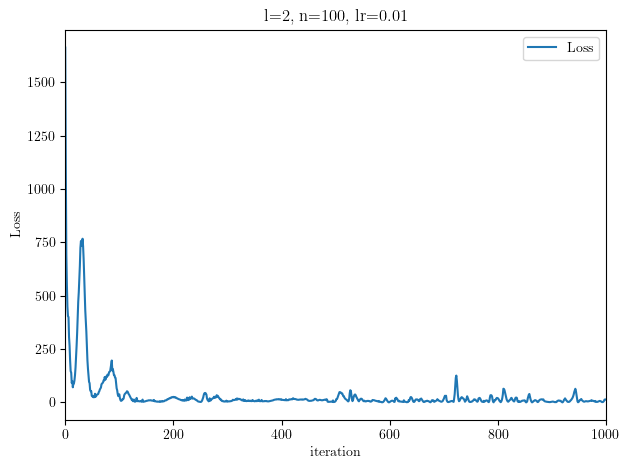

In [33]:

plt.plot(L_loss, label='Loss')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.title(f'l={res["layers"]}, n={res["neurons"]}, lr={res["lr"]}')
plt.legend()
plt.grid(False)
#plt.set_ylim(y_min, y_max)
plt.xlim(0, ITERATIONS)
plt.tight_layout()
# Show the plot
plt.show()

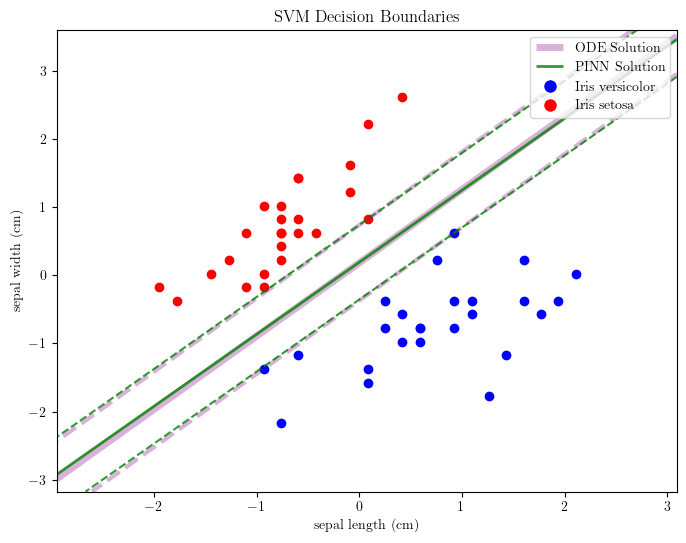

Variables: [ 1.9289036  -1.8254046   0.34842932]
Constraints: [-2.380275    0.00154518 -0.89866406 -1.7840309   0.00356312 -1.2635581
 -1.6284523  -1.5117685  -0.9375587  -2.5118012  -1.2466979  -2.146907
 -0.45598063 -3.3731158  -1.8986969  -0.40022567 -1.3950845  -0.5337699
 -1.9155573  -0.34648865 -1.8209076  -2.0153809  -1.2078032  -0.49487525
 -2.6305032  -0.5169096  -2.5527139  -2.3971353  -1.3024528  -2.550696
 -2.0859783  -1.8449599  -2.319346   -5.027166   -2.263591   -1.8986969
 -1.9933465  -0.12998112 -2.0302231  -1.2635581  -1.9375916  -0.05938379
 -3.1249056  -1.0542426  -3.8157992  -3.7769046  -0.6115592  -4.258483
 -1.4728738  -2.3971353 ]


In [34]:
T=50.0
net = res['net']
res_ = net(torch.tensor([T]).cuda()).cpu().detach().numpy()
plot_svm_decision_boundary_confrontation_PINN(selected_X, selected_y, w_ode, b_ode, res_[:data_X.shape[1]], res_[data_X.shape[1]], 0, 1)
print('Variables:', res_[:nx])
print('Constraints:', g(res_[:nx]))